# DETECCIÓN Y CONTEO DE PALMAS
 ---------------------

 El siguiente script tiene por objetivo cargar un video de ### minutos de duración y obtener un nuevo video detectando los frutos que salen del camión y realizando un conteo de los mismos. Se reliza el siguiente proceso.

 - (1) Ajuste del entorno de trabajo/ conexión drive/ carga librerias
 - (2) Carga del video
 - (3) Creación de fotogramas
 - (4) Llamado al modelo entrenado YOLO
 - (5) Creación de fotogramas incorporando un recuadro delimitador de reconocimiento y un conteo de frutos en la parte superior izquierda
 - (6) Creación del nuevo video considerando la nueva ruta de fotogramas modificados


### (1) Ajustando el entorno de trabajo

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-gpu

# !pip uninstall tensorflow-gpu
# !pip install tensorflow-gpu

In [3]:
%%capture

!pip install ultralytics

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
import tqdm

from pathlib import Path

import tensorflow
import datetime

import numpy as np

### (2) Carga del video y creación de rutas

In [5]:
# Directorio donde se guardarán los fotogramas
output_dir = '/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_input'
os.makedirs(output_dir, exist_ok=True)

output_folder = '/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput'
os.makedirs(output_folder, exist_ok=True)

video_path = '/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/Video_input/Rampa_02_TULUMAYO_TULUMAYO_video.avi'
cap = cv2.VideoCapture(video_path)


# Verificar si el video se cargó correctamente
if not cap.isOpened():
    print("Error al abrir el video.")
    exit()

### (3) creación de fotogramas, se ajustan los margenes de reducción de img

In [12]:
# Leer el primer fotograma
ret, frame = cap.read()
# Almacenar el primer fotograma como objeto en la sesión de Colab
primer_fotograma = frame.copy()

# Obtener las dimensiones del fotograma
height, width, _ = frame.shape

# Calcular las coordenadas del rectángulo
x_vf = int(width * 0.34)   # 0.42
y_vf = int(height * 0.07)  # 0.10
w_vf = int(width * 0.25)   # 0.15
h_vf = int(height * 0.35)  # 0.30


# Liberar los recursos
cap.release()

# Dibujar el rectángulo en el primer fotograma
cv2.rectangle(primer_fotograma, (x_vf, y_vf), (x_vf + w_vf, y_vf + h_vf), (0, 255, 0), 2)

cv2_imshow(primer_fotograma)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# CONTANDO UN INTERVALO DE SEGUNDOS
# ----

# Duración en segundos desde el inicio del video hasta el minuto a realizar los frames
start_time = datetime.timedelta(minutes=2, seconds=00)

# Duración en segundos del intervalo a capturar (2 minutos)
duration_to_capture = 240

# Avanzar hasta el tiempo de inicio
cap.set(cv2.CAP_PROP_POS_MSEC, start_time.total_seconds() * 1000)

frame_count = 0
while cap.isOpened() and frame_count < duration_to_capture * cap.get(cv2.CAP_PROP_FPS):
    ret, frame = cap.read()
    if not ret:
        break

    # Obtener las dimensiones del fotograma
    height, width, _ = frame.shape

    # Calcular las coordenadas del rectángulo
    x = x_vf
    y = y_vf
    w = w_vf
    h = h_vf

    # Recortar el fotograma según el rectángulo
    frame_recortado = frame[y+2:y+h-2, x+2:x+w-2]  # Ajustar las coordenadas para quitar el borde

    # Guardar el fotograma como imagen
    frame_path = os.path.join(output_folder, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_path, frame_recortado)

    frame_count += 1

# Liberar los recursos
cap.release()
cv2.destroyAllWindows()

# print(f'Se han guardado {frame_count} fotogramas desde el minuto {start_time.minutes} : {start_time.seconds} , se han considerado {duration_to_capture} segundos en: {output_folder}')


### (4) Llamado al modelo entrenado YOLO

In [9]:
# Cargamos el modelo pre entradodo YOLO
# -----------------------

model = YOLO('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/Palmas_demoTL_3/model/runs/detect/train/weights/best.onnx')

In [ ]:
print(model)

YOLO()


### (5) Creación de fotogramas incorporando un recuadro delimitador de reconocimiento y un conteo de frutos en la parte superior izquierda

In [7]:
# Directorio de uso de fotogramas
# -----------------------
input_dir = Path(output_folder)

# Guardamos la ruta donde se almacenaran las detecciones predichas
# -----------------------
output_dir_positives = Path('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_predict')


# creamos el archivo filenames para guardar todas las rutas de fotogramas
# -----------------------
filenames = list(input_dir.glob('*.jpg')) # Lista de imagenes originales para detectar
filenames.sort()
filenames

[PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0000.jpg'),
 PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0001.jpg'),
 PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0002.jpg'),
 PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0003.jpg'),
 PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0004.jpg'),
 PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0005.jpg'),
 PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0006.jpg'),
 PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_V

##### (5.1) Detección de fotogramas - PALMAS DETECTOR

In [ ]:
### #                                                                               # ###
### # PROTOTIPO 001 # <<< Detección de objetos (Palmas) con Python, YOLOv8 y OpenCV # ###
### # ############################################################################# # ###
### # ############################################################################# # ###


for image_path in tqdm.tqdm(filenames, total=len(filenames)):
  results = model(image_path)

  # Cargar la imagen original para dibujar los recuadros delimitadores
  image = cv2.imread(str(image_path))

  # Dibujar los recuadros delimitadores y las etiquetas en la imagen
  if len(results[0].boxes) > 0:
      for box in results[0].boxes:
          # Coordenadas del recuadro delimitador
          xmin, ymin, xmax, ymax = box.xyxy[0].tolist()

          # Dibujar el recuadro delimitador en la imagen
          start_point = (int(xmin), int(ymin))
          end_point = (int(xmax), int(ymax))
          color = (0, 255, 0)  # Color verde para el recuadro
          thickness = 2
          image = cv2.rectangle(image, start_point, end_point, color, thickness)

          # Añadir etiqueta de clase (opcional)
          # class_name = results[0].names[box.class_id]
          # cv2.putText(image, 'Fruto detectado', (int(xmin), int(ymin - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

          # Añadir etiqueta de clase y probabilidad de detección
          confidence = box.conf.item()  # Obtener la probabilidad de detección
          label = f'Palma ({confidence:.2f})'
          cv2.putText(image, label, (int(xmin), int(ymin - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

  # Mostrar la imagen con recuadros delimitadores
  # print(results)
  # cv2_imshow(image)

  # Obtener el nombre base de la imagen
  base_name = os.path.splitext(os.path.basename(image_path))[0]

  # Ruta para guardar las imágenes
  output_folder = output_dir_positives
  os.makedirs(output_folder, exist_ok=True)

  # Guardar la imagen con un nombre único basado en el nombre base y la probabilidad de detección
  # output_image_path = os.path.join(output_folder, f'{base_name}_{confidence:.2f}.jpg')
  output_image_path = os.path.join(output_folder, f'{base_name}.jpg')

  cv2.imwrite(output_image_path, image)

100%|██████████| 5340/5340 [23:31<00:00,  3.78it/s]


In [ ]:
# Creación del video de salida
# -------------------
# -----------------

# Nombre del archivo de video de salida
output_video = '/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/Video_predict/video_salida.avi'

# Resolución del video (ancho y alto en píxeles)
width, height = 640, 480

# Configurar el codec de video
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Inicializar el objeto VideoWriter
out = cv2.VideoWriter(output_video, fourcc, 20.0, (width, height))

# Iterar sobre las imágenes en el directorio
for filename in filenames:
  filename_str = str(filename)

  if filename_str.endswith(".jpg"):
    # Cargar la imagen
    image_path = os.path.join(output_dir, filename_str)
    image = cv2.imread(image_path)

    # Redimensionar la imagen a la resolución deseada
    image_resized = cv2.resize(image, (width, height))

    # Escribir el fotograma en el video
    out.write(image_resized)

# Liberar los recursos
out.release()

print(f'Se ha creado el video {output_video} a partir de las imágenes en {output_dir_positives}')


Se ha creado el video /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/Video_predict/video_salida.avi a partir de las imágenes en /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_predict


In [ ]:
output_folder

In [ ]:
output_dir

'/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_input'

##### (5.2) Detección y contador de fotogramas - PALMAS DETECTOR and COUNT

In [ ]:
# Ajustamos las coordenadas del intervalo de conteo
# ----------------------------------------

image_path = filenames[6]
# --
results = model(image_path)

# Cargar la imagen original para dibujar los recuadros delimitadores
image = cv2.imread(str(image_path))


palma_counter = 0
# Dibujar los recuadros delimitadores y las etiquetas en la imagen
if len(results[0].boxes) > 0:
    for box in results[0].boxes:
        # Coordenadas del recuadro delimitador
        xmin, ymin, xmax, ymax = box.xyxy[0].tolist()

        # Dibujar el recuadro delimitador en la imagen
        start_point = (int(xmin), int(ymin))
        end_point = (int(xmax), int(ymax))
        color = (0, 255, 0)  # Color verde para el recuadro
        thickness = 2
        image = cv2.rectangle(image, start_point, end_point, color, thickness)

        # Añadir etiqueta de clase (opcional)
        # class_name = results[0].names[box.class_id]
        # cv2.putText(image, 'Fruto detectado', (int(xmin), int(ymin - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Añadir etiqueta de clase y probabilidad de detección
        confidence = box.conf.item()  # Obtener la probabilidad de detección
        label = f'Palma ({confidence:.2f})'
        cv2.putText(image, label, (int(xmin), int(ymin - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Generando 2 lineas de intervalo para el punto superior derecho del recuadro delimitador
        # --------------------
        # --------------------
        # Coordenadas del punto superior derecho del cuadro delimitador
        # top_right_point = (int(xmax), int(ymin)) # Image referncia para lineas delimitadoras
        top_right_point = (668, 403)

        # Distancia desde top_right_point para las líneas paralelas
        line_length = 60
        distance_rigth = 4
        distance_left = 4

        # Calcular las coordenadas de los puntos finales de las líneas paralelas al eje y
        coord_x_line1 = top_right_point[0] + distance_left
        line1_start = (top_right_point[0] + distance_left, top_right_point[1] - line_length)
        line1_end = (top_right_point[0] + distance_left, top_right_point[1] + line_length)

        coord_x_line2 = top_right_point[0] - distance_rigth
        line2_start = (top_right_point[0] - distance_rigth, top_right_point[1] + line_length)
        line2_end = (top_right_point[0] - distance_rigth, top_right_point[1] - line_length)

        # Dibujar las líneas en la imagen
        image = cv2.line(image, line1_start, line1_end, (255, 0, 0), 2)
        image = cv2.line(image, line2_start, line2_end, (255, 0, 0), 2)

        # Realizando el conteo
        # -----------
        if coord_x_line2 < (int(xmax)) < coord_x_line1:
          palma_counter = palma_counter + 1

        # Dibujar el contador en la imagen
        counter_text = f"Palmas: {palma_counter}"
        cv2.putText(image, counter_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Mostrar la imagen con recuadros delimitadores
# print(results)
print('Palmas: ',palma_counter)
cv2_imshow(image)

# Obtener el nombre base de la imagen
# base_name = os.path.splitext(os.path.basename(image_path))[0]

# Ruta para guardar las imágenes
# output_folder = output_dir_positives
# os.makedirs(output_folder, exist_ok=True)

# Guardar la imagen con un nombre único basado en el nombre base y la probabilidad de detección
# output_image_path = os.path.join(output_folder, f'{base_name}_{confidence:.2f}.jpg')
# output_image_path = os.path.join(output_folder, f'{base_name}.jpg')

# cv2.imwrite(output_image_path, image)

In [16]:
(403+50, 304+50)

(453, 354)

In [17]:
int(xmax), int(ymin)

(668, 403)

In [10]:
### #                                                                       # ###
### # PROTOTIPO 002 # <<< Contador de (Palmas) con Python, YOLOv8 y OpenCV  # ###
### # ##################################################################### # ###
### # ##################################################################### # ###

palma_counter = 0

for image_path in tqdm.tqdm(filenames, total=len(filenames)):
  results = model(image_path)

  # Cargar la imagen original para dibujar los recuadros delimitadores
  image = cv2.imread(str(image_path))

  # Dibujar los recuadros delimitadores y las etiquetas en la imagen
  if len(results[0].boxes) > 0:
       for box in results[0].boxes:
          # Coordenadas del recuadro delimitador
          xmin, ymin, xmax, ymax = box.xyxy[0].tolist()

          # Dibujar el recuadro delimitador en la imagen
          start_point = (int(xmin), int(ymin))
          end_point = (int(xmax), int(ymax))
          color = (0, 255, 0)  # Color verde para el recuadro
          thickness = 2
          image = cv2.rectangle(image, start_point, end_point, color, thickness)

          # Añadir etiqueta de clase (opcional)
          # class_name = results[0].names[box.class_id]
          # cv2.putText(image, 'Fruto detectado', (int(xmin), int(ymin - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

          # Añadir etiqueta de clase y probabilidad de detección
          confidence = box.conf.item()  # Obtener la probabilidad de detección
          label = f'Palma ({confidence:.2f})'
          cv2.putText(image, label, (int(xmin), int(ymin - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


          # Generando 2 lineas de intervalo para el punto superior derecho del recuadro delimitador
          # --------------------
          # --------------------
          # Coordenadas del punto superior derecho del cuadro delimitador
          # top_right_point = (int(xmax), int(ymin)) # Image referncia para lineas delimitadoras
          top_right_point = (668, 403)

          # Distancia desde top_right_point para las líneas paralelas
          line_length = 60
          distance_rigth = 4
          distance_left = 4

          # Calcular las coordenadas de los puntos finales de las líneas paralelas al eje y
          coord_x_line1 = top_right_point[0] + distance_left
          line1_start = (top_right_point[0] + distance_left, top_right_point[1] - line_length)
          line1_end = (top_right_point[0] + distance_left, top_right_point[1] + line_length)

          coord_x_line2 = top_right_point[0] - distance_rigth
          line2_start = (top_right_point[0] - distance_rigth, top_right_point[1] + line_length)
          line2_end = (top_right_point[0] - distance_rigth, top_right_point[1] - line_length)

          # Dibujar las líneas en la imagen
          # image = cv2.line(image, line1_start, line1_end, (255, 0, 0), 2)
          # image = cv2.line(image, line2_start, line2_end, (255, 0, 0), 2)

          # Realizando el conteo
          # -----------
          if coord_x_line2 < (int(xmax)) < coord_x_line1:
            palma_counter = palma_counter + 1

          # Dibujar el contador en la imagen
          counter_text = f"Palmas: {palma_counter}"
          cv2.putText(image, counter_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

  else:
    # Dibujar el contador en la imagen
    counter_text = f"Palmas: {palma_counter}"
    cv2.putText(image, counter_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)



  # Mostrar la imagen con recuadros delimitadores
  # print(results)
  # cv2_imshow(image)

  # Obtener el nombre base de la imagen
  base_name = os.path.splitext(os.path.basename(image_path))[0]

  # Ruta para guardar las imágenes
  output_folder = output_dir_positives
  os.makedirs(output_folder, exist_ok=True)

  # Guardar la imagen con un nombre único basado en el nombre base y la probabilidad de detección
  # output_image_path = os.path.join(output_folder, f'{base_name}_{confidence:.2f}.jpg')
  output_image_path = os.path.join(output_folder, f'{base_name}.jpg')

  print('Nro de Palmas: ', palma_counter)
  cv2.imwrite(output_image_path, image)

  0%|          | 0/5340 [00:00<?, ?it/s]

Loading /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/Palmas_demoTL_3/model/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirements ['onnx', 'onnxruntime'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 191.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 234.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 165.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 122.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 13.3s, installed 2 packages: ['onnx', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0000.jpg: 640x640 1 palma, 222.0ms
Speed: 64.7ms preprocess, 222.0ms inference, 2702.4ms postprocess per image at shape (1, 3, 640, 6

  0%|          | 1/5340 [00:19<29:20:06, 19.78s/it]

Nro de Palmas:  0

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0001.jpg: 640x640 1 palma, 175.7ms
Speed: 4.9ms preprocess, 175.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 2/5340 [00:20<12:43:30,  8.58s/it]

Nro de Palmas:  0

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0002.jpg: 640x640 1 palma, 173.4ms
Speed: 4.0ms preprocess, 173.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 3/5340 [00:21<7:30:07,  5.06s/it] 

Nro de Palmas:  0

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0003.jpg: 640x640 1 palma, 184.4ms
Speed: 4.1ms preprocess, 184.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 4/5340 [00:22<4:58:06,  3.35s/it]

Nro de Palmas:  0

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0004.jpg: 640x640 1 palma, 175.6ms
Speed: 3.9ms preprocess, 175.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 5/5340 [00:22<3:34:01,  2.41s/it]

Nro de Palmas:  0

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0005.jpg: 640x640 2 palmas, 280.8ms
Speed: 5.4ms preprocess, 280.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 6/5340 [00:23<2:45:15,  1.86s/it]

Nro de Palmas:  0

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0006.jpg: 640x640 1 palma, 268.8ms
Speed: 4.7ms preprocess, 268.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 7/5340 [00:24<2:15:28,  1.52s/it]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0007.jpg: 640x640 2 palmas, 289.9ms
Speed: 5.8ms preprocess, 289.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 8/5340 [00:25<1:57:02,  1.32s/it]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0008.jpg: 640x640 1 palma, 178.2ms
Speed: 5.1ms preprocess, 178.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 9/5340 [00:26<1:40:08,  1.13s/it]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0009.jpg: 640x640 1 palma, 175.4ms
Speed: 4.1ms preprocess, 175.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 10/5340 [00:26<1:28:25,  1.00it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0010.jpg: 640x640 1 palma, 183.7ms
Speed: 5.1ms preprocess, 183.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 11/5340 [00:27<1:20:33,  1.10it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0011.jpg: 640x640 (no detections), 170.1ms
Speed: 4.8ms preprocess, 170.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 12/5340 [00:28<1:15:15,  1.18it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0012.jpg: 640x640 1 palma, 171.6ms
Speed: 4.7ms preprocess, 171.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 13/5340 [00:28<1:11:41,  1.24it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0013.jpg: 640x640 (no detections), 169.7ms
Speed: 3.9ms preprocess, 169.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 14/5340 [00:29<1:08:37,  1.29it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0014.jpg: 640x640 (no detections), 162.8ms
Speed: 4.0ms preprocess, 162.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 15/5340 [00:30<1:06:05,  1.34it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0015.jpg: 640x640 (no detections), 164.0ms
Speed: 3.5ms preprocess, 164.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 16/5340 [00:30<1:03:53,  1.39it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0016.jpg: 640x640 (no detections), 160.3ms
Speed: 3.5ms preprocess, 160.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 17/5340 [00:31<1:04:39,  1.37it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0017.jpg: 640x640 (no detections), 171.4ms
Speed: 3.5ms preprocess, 171.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 18/5340 [00:32<1:04:22,  1.38it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0018.jpg: 640x640 (no detections), 181.9ms
Speed: 3.4ms preprocess, 181.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 19/5340 [00:33<1:04:26,  1.38it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0019.jpg: 640x640 (no detections), 160.8ms
Speed: 3.3ms preprocess, 160.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 20/5340 [00:33<1:04:48,  1.37it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0020.jpg: 640x640 (no detections), 187.7ms
Speed: 4.0ms preprocess, 187.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 21/5340 [00:34<1:04:34,  1.37it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0021.jpg: 640x640 (no detections), 413.4ms
Speed: 4.1ms preprocess, 413.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 22/5340 [00:35<1:12:34,  1.22it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0022.jpg: 640x640 (no detections), 715.8ms
Speed: 6.7ms preprocess, 715.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 23/5340 [00:36<1:23:48,  1.06it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0023.jpg: 640x640 (no detections), 273.8ms
Speed: 5.1ms preprocess, 273.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 24/5340 [00:37<1:21:41,  1.08it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0024.jpg: 640x640 (no detections), 276.1ms
Speed: 5.1ms preprocess, 276.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 25/5340 [00:38<1:18:11,  1.13it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0025.jpg: 640x640 (no detections), 168.8ms
Speed: 4.0ms preprocess, 168.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 26/5340 [00:39<1:15:29,  1.17it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0026.jpg: 640x640 (no detections), 175.9ms
Speed: 4.1ms preprocess, 175.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 27/5340 [00:40<1:12:24,  1.22it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0027.jpg: 640x640 (no detections), 176.0ms
Speed: 3.7ms preprocess, 176.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 28/5340 [00:40<1:10:29,  1.26it/s]

Nro de Palmas:  1

image 1/1 /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_ouput/frame_0028.jpg: 640x640 (no detections), 159.9ms
Speed: 3.5ms preprocess, 159.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 29/5340 [00:41<1:08:48,  1.29it/s]

Nro de Palmas:  1



  1%|          | 29/5340 [00:42<2:08:28,  1.45s/it]


KeyboardInterrupt: 

In [25]:
primer_fotograma_img =  cv2.imread('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_predict/frame_0000.jpg')

626 796


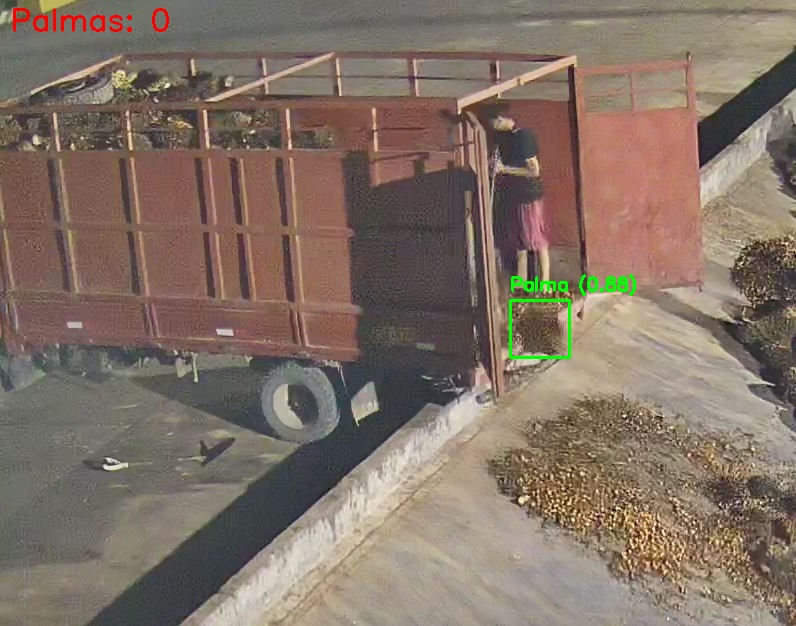

In [26]:
# Obtener las dimensiones del fotograma
height_one, width_one, _ = primer_fotograma_img.shape

print(height_one, width_one)
cv2_imshow(primer_fotograma_img)

In [30]:
# Creación del video de salida
# -------------------
# -----------------

# Nombre del archivo de video de salida
output_video = '/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/Video_predict/video_salida_count_2.avi'

# Resolución del video (ancho y alto en píxeles)
width, height = width_one, height_one

# Configurar el codec de video
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Inicializar el objeto VideoWriter
out = cv2.VideoWriter(output_video, fourcc, 20.0, (width, height))

# Iterar sobre las imágenes en el directorio
for filename in filenames:
  filename_str = str(filename)

  if filename_str.endswith(".jpg"):
    # Cargar la imagen
    image_path = os.path.join(output_dir_positives, filename_str)
    image = cv2.imread(image_path)

    # Redimensionar la imagen a la resolución deseada
    image_resized = cv2.resize(image, (width, height))

    # Escribir el fotograma en el video
    out.write(image_resized)

# Liberar los recursos
out.release()

print(f'Se ha creado el video {output_video} a partir de las imágenes en {output_dir_positives}')


Se ha creado el video /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/Video_predict/video_salida_count_2.avi a partir de las imágenes en /content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_predict


In [28]:
output_dir

'/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_input'

In [29]:
output_dir_positives

PosixPath('/content/drive/MyDrive/01_Practicas_DATA_SCIENCE/Practicas_DL/PRODUTIVO_DEMO_VIDEO/fotogramas_predict')